### Max-Cut problem

Max-Cut es un problema de teoría de grafos que consiste en particionar un grafo separando los vértices en dos subconjuntos disjuntos de manera tal, que el número de aristas que contengan un vértice de cada conjunto sea máximo. 

En este tutorial vamos a ver:
 - Entender el problema Max-Cut con un ejemplo.
 - Cómo formular Mux-Cut como un problema QUBO.
 - Resolver el Max-Cut utilizando el algoritmo QAOA.


Un grafo es un par $G=(V,E)$ donde $V$ es un conjunto de vértices y $E$ es un conjunto de aristas que unen esos vértices y cuyos elementos se representan como pares de elementos tomados de V.

El siguiente es un ejemplo de grafo sobre el que vamos a trabajar para entender el problema Max-Cut.

Sea $V = \{A, B, C, D\}$ el conjunto de vértices y $E = \{(A, B), (B, C), (C, D), (D, A)\}$ el conjunto de aristas que unen esos vértices.

Por sencillez estamos trabajando con un grafo no dirigido en el que las aristas son no dirigidas, o lo que es lo mismo $(A,B)$ es el mismo elemento que $(B,A)$.

Visualicemos el grafo.

Conjunto de Vértices: ['A', 'B', 'C', 'D']
Conjunto de Aristas: [('A', 'B'), ('A', 'D'), ('B', 'C'), ('C', 'D')]


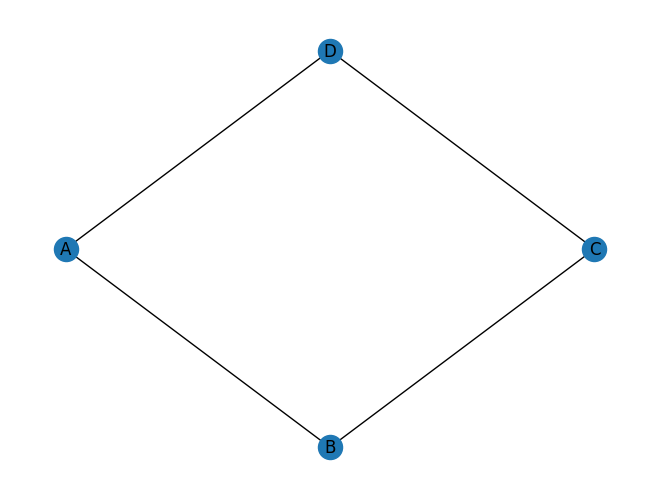

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.Graph()

# Conjunto de vértices
V = ["A", "B", "C", "D"]
# Conjunto de aristas 
E = [("A", "B"), ("B", "C"), ("C", "D"), ("D", "A")]

graph.add_nodes_from(V) # Añadimos los nodos al grafo
graph.add_edges_from(E) # Añadimos las aristas al grafo

print(f"Conjunto de Vértices: {graph.nodes}")
print(f"Conjunto de Aristas: {graph.edges}")

nx.draw_shell(graph, with_labels=True)

Supongamos que hacemos la siguiente $\textbf{partición}$ $V_1=\{A,B\}$ y $V_2=\{C,D\}$ que cumple las condiciones $V_1 \cup V_2 = V$ y $V_1 \cap V_2 = \varnothing$. Es decir, $V_1$ y $V_2$ son complementarios en $V$.

Dibujemos el grafo con los colores rojo para los vértices de $V_1$ y azul para los vértices de $V_2$.

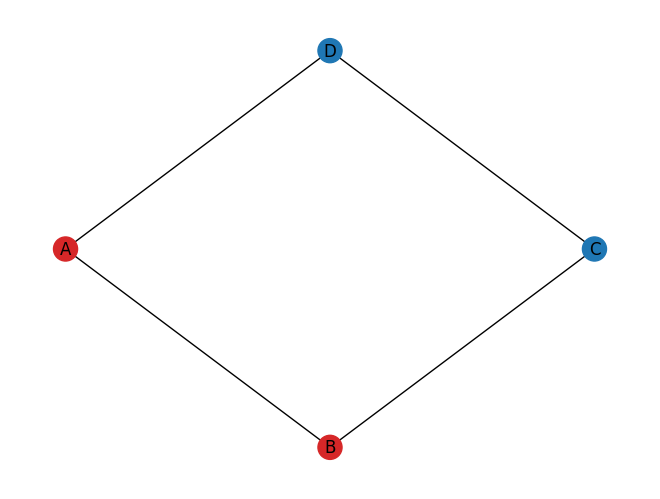

In [72]:
nx.draw_shell(graph, with_labels=True, node_color=["tab:red" if n in ("A", "B") else "tab:blue" for n in graph])

Vamos a formar un conjunto con las aristas que tienen un vértice rojo y otro vértice azul $S = \{(A,D), (B,C)\} \subset E$, a este conjunto lo vamos a llamar $\textbf{corte}$ y al número de elementos que contiene $|S|=2$ lo llamaremos $\textbf{valor del corte}$.

¿Podemos encontrar otra partición del conjunto $V$ de tal manera que el valor $|S|$ se mayor que 2?

Para responder a esta pregunta vamos a considerar la siguiente partición: $V_1 = \{A,C\}$ y $V_2 = \{B,D\}$ y visualicemos cómo nos queda el grafo.

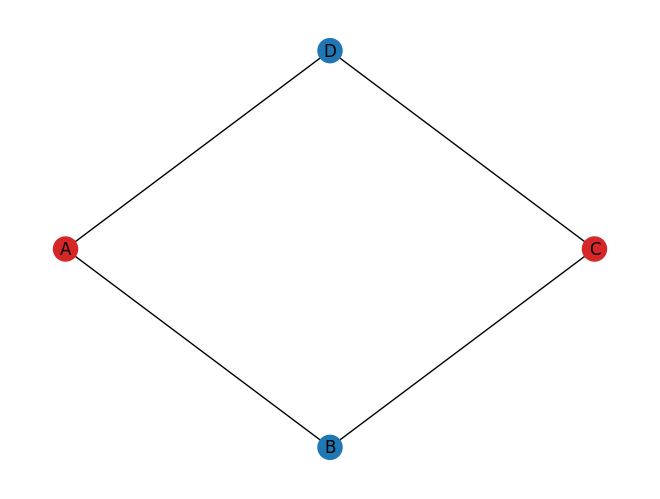

In [78]:
nx.draw_shell(graph, with_labels=True, node_color=["tab:red" if n in ("A", "C") else "tab:blue" for n in graph])

Construimos ahora el corte $S$ formado por las aristas que tienen distinto color $S = \{(A,B), (B,C), (C,D), (D,A)\} = E$ y su valor de corte es $|S| = 4$, siendo éste el máximo valor que podemos alcanzar ya que no hay más aristas. Hemos alcanzado el máximo corte.

En esto consiste el problema Max-Cut, dado un grafo $G(V,E)$ encontrar un corte $S \subseteq E$ tal que $|S|$ sea el máximo posible.

### Formulación QUBO

En el apartado anterior hemos visto cómo resolver el problema Max-Cut con un grafo de cuatro vértices pero ¿y si el grafo tuviera 500 vértices? Sería mucho más complicado resolverlo a mano. En este apartado presentaremos la formulación QUBO (Quadratic Unconstrained Binary Optimization) para resolver este problema. 

Para ello, utilizaremos el grafo con el primer corte que hicimos pero usando números naturales para etiquetar los vértices.

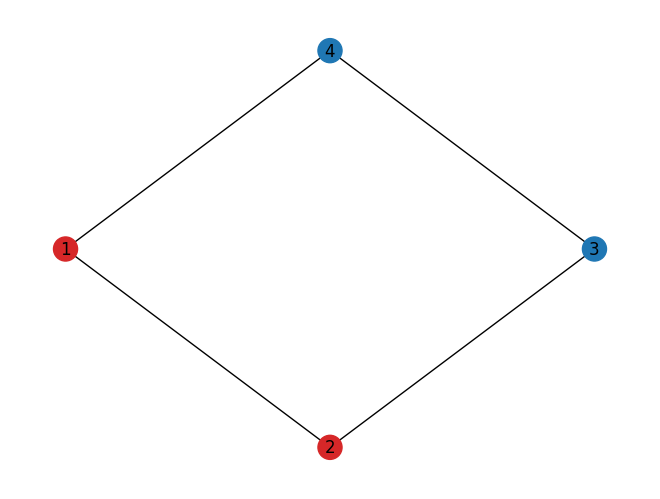

In [79]:
number_graph = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1)])

nx.draw_shell(number_graph, with_labels=True, node_color=["tab:red" if n in (1,2) else "tab:blue" for n in number_graph])

Definimos cuatro variables binarias $x_1, x_2, x_3, x_4$ que toman valores entre 0 o 1 y cuyo índice indica a qué vértice representa. Podemos convenir en que el valor 1 represente el color rojo y el valor 0 el color azul. 

Observando el grafo anterior vemos que las variables toman los siguientes valores $x_1 = x_2 = 1$ y $x_3 = x_4 = 0$.

Podemos representar la partición del grafo por el vector $\vec{x} = (x_1,x_2,x_3,x_4) = (1,1,0,0)$ y buscar una expresión para una función $C(x_1, x_2, x_3, x_4)$ para que nos de el número de aristas que tienen diferente color, lo que sería equivalente a encontrar el valor del corte del que hablamos en el apartado anterior.

Para el grafo que sobre el que estamos trabajando tenemos que $C(1,1,0,0) = 2$.

Nuestro primer objetivo es cómo determinar si una arista tiene un vértice de color rojo y otro de color azul. 

Podemos probar sumando ambos valores de las variables de cada vértice:

$$
\begin{align*}
x_1 + x_4 = 1 + 0 = 1 \\
x_2 + x_3 = 1 + 0 = 1 \\
x_1 + x_2 = 1 + 1 = 2 \\
x_3 + x_4 = 0 + 0 = 0
\end{align*}
$$

Este método funciona bien para saber si una arista tiene un vértice de cada color, ambos de color rojo o ambos de color azul pero no nos ayuda a calcular el máximo corte.

Probemos multiplicando:

$$
\begin{align*}
x_1 · x_4 = 1 · 0 = 0 \\
x_2 · x_3 = 1 · 0 = 0 \\
x_1 · x_2 = 1 · 1 = 1 \\
x_3 · x_4 = 0 · 0 = 0
\end{align*}
$$

Ahora solo podemos saber cuándo dos aristas son rojas, lo cual no nos ayuda mucho. Vamos a hacerle una pequeña variación a la multiplicación y restemos a 1 el valor de la variable de la derecha:

$$
\begin{align*}
x_1 · (1 - x_4) = 1 · (1 - 0) = 1 \\
x_2 · (1 - x_3) = 1 · (1 - 0) = 1 \\
x_1 · (1 - x_2) = 1 · (1 - 1) = 0 \\
x_3 · (1 - x_4) = 0 · (1 - 0) = 0
\end{align*}
$$

Este cálculo si es prometedor, hemos definido una función $f(x_i, x_j) = x_i·(1-x_j)$ que dados dos vértices nos devuelve 1 si ambos vértices son de distinto color y 0 si son del mismo color y además podemos calcular el valor del corte del grafo sumando todos los términos. Parece que vamos en buen camino de encontrar una fórmula para calcular el máximo corte.

Podríamos encontrar una pega a la fórmula anterior ya que $f(x_4, x_1) = x_4 · (1 - x_1) = 0 · (1 - 1) = 0$ y la arista $(4,1)$ tiene vértices de distinto color. Sin embargo, pronto veremos que esto no supone ningún problema.

Definamos la siguiente función:

$$
\begin{align*}
C(x_1, x_2, x_3, x_4) = \sum_{i=1}^{4} \sum_{j=1}^{4} x_i·(1 - x_j) & = x_1·(1-x_1) + x_1·(1-x_2) + x_1·(1-x_3) + x_1·(1-x_4) + \\
& + x_2·(1-x_1) + x_2·(1-x_2) + x_2·(1-x_3) + x_2·(1-x_4) + \\
& + x_3·(1-x_1) + x_3·(1-x_2) + x_3·(1-x_3) + x_3·(1-x_4) + \\
& + x_4·(1-x_1) + x_4·(1-x_2) + x_4·(1-x_3) + x_4·(1-x_4) 
\end{align*}
$$

Hemos construido una función que para una partición de un grafo nos devuelve el corte de esa partición:

$$C: \{0,1\}^4 \rightarrow \mathbb{Z}$$  

Vamos a analizar algunos términos de la función anterior a ver si tenemos que modificarla.

Existen tres tipos de términos en la suma anterior:
 - Los términos no nulos y legítimos $x_1·(1-x_4)$ y $x_2·(1-x_3)$ ambos valen 1.
 - Los términos nulos, que son la gran mayoría de ellos. Son los términos de la diagonal, los recíprocos de los anteriores y los correspondientes a los vértices del mismo color.
 - Los términos fantasma, son los correspondientes a aristas que no existen.

De todos ellos los que más nos fastidian son los términos fantasma, que son cuatro:

$$
\begin{align*}
x_1·(1-x_4) = 1 \\
x_2·(1-x_3) = 1 \\
x_4·(1-x_1) = 0 \\
x_3·(1-x_2) = 0
\end{align*}
$$

Vemos que estos términos aportan un valor de 2 a la suma, obteniendo un total de 4 para la partición dada que no es el valor correcto.

Para corregir esto introduciremos unos pesos $w_{ij}$ que valen 1 si entre los vértices i y j hay una arista y 0 en caso contrario. 

Para el grafo con el que estamos trabajando tenemos $w_{12} = w_{21} = w_{23} = w_{32} = w_{34} = w_{43} = w_{14} = w_{41} = 1$, el resto de coeficientes son 0.

Podemos reescribir la fórmula anterior:

$$
\begin{align*}
C(x_1, x_2, x_3, x_4) = \sum_{i=1}^{4} \sum_{j=1}^{4} w_{ij}x_i·(1 - x_j) & = w_{11}·x_1·(1-x_1) + w_{12}·x_1·(1-x_2) + w_{13}·x_1·(1-x_3) + w_{14}·x_1·(1-x_4) + \\
& + w_{21}·x_2·(1-x_1) + w_{22}·x_2·(1-x_2) + w_{23}·x_2·(1-x_3) + w_{24}·x_2·(1-x_4) + \\
& + w_{31}·x_3·(1-x_1) + w_{32}·x_3·(1-x_2) + w_{33}·x_3·(1-x_3) + w_{34}·x_3·(1-x_4) + \\
& + w_{41}·x_4·(1-x_1) + w_{42}·x_4·(1-x_2) + w_{43}·x_4·(1-x_3) + w_{44}·x_4·(1-x_4)   \\
\end{align*}
$$

Eliminando los términos que tienen pesos nulos, agrupando términos recíprocos y simplificando nos queda:

$$
\begin{align*}
C(x_1, x_2, x_3, x_4) & = x_1·(1-x_2) + x_1·(1-x_4) + x_2·(1-x_1) + x_2·(1-x_3) + x_3·(1-x_2) + x_3·(1-x_4) + x_4·(1-x_1) + x_4·(1-x_3) \\
                      & = [x_1·(1-x_2) + x_2·(1-x_1)] + [x_2·(1-x_3) + x_3·(1-x_2)] + [x_3·(1-x_4) + x_4·(1-x_3)] + [x_4·(1-x_1) + x_1·(1-x_4)] \\
                      & = \sum_{(ij)} x_i·(1-x_j) + x_j·(1-x_i) \\
                      & = \sum_{(ij)} x_i + x_j -2x_ix_j
\end{align*}
$$




Téngase en cuenta que el sumatorio obtenido significa sumar para todas las aristas del grafo.

En la formulación QUBO el problema Max-Cut consiste en encontrar el máximo de la función anterior, para el caso de n vértices sería:

$$
\max_{x \in \{0,1\}^n} \sum_{(ij)} x_i + x_j -2x_ix_j
$$

### Algoritmo QAOA

En este apartado vamos a describir cómo funciona el algoritmo QAOA (Quantum Approximate Optimization Algorithm) y lo aplicaremos para resolver el problema Max-Cut.

El algoritmo QAOA está inspirado en el modo de operar de los annealers que son los computadores que utilizan la computación adiabática y la cuál explicaré en otro notebook.

#### Preámbulo Adiabático
En computación adiabática partimos del Hamiltoniano siguiente:

$$
H(t) = A(t)H_0 + B(t)H_1
$$

Es dependiente del tiempo y evoluciona de manera continua en el intervalo $[0, T]$. Resolviendo la ecuación de Schrödinger para este sistema podemos obtener el vector de estado $\ket{\psi{(t)}}$ en cualquier momento $t \in [0,T]$

$$
\ket{\psi{(t)}} = e^{-it\mathbf{H}(t)} \ket{\psi{(0)}}
$$

siendo $U(0,t)=e^{-it\mathbf{H}(t)}$ el operador evolución entre los instantes $t_0=0$ y $t_1=t$ y que podemos definirlo de manera genérica como:

$$
U(t_0,t_1)=e^{-i(t_1 - t_0)\mathbf{H}(t_0)}
$$

Para simular este comportamiento con puertas cuánticas necesitamos discretizar el dominio $[0,T]$.

Vamos a considerar intervalos de tiempo $\triangle t$ lo suficientemente pequeños como para que el Hamiltoniano sea prácticamente constante en el intervalo $[t_k, t_k + \triangle t]$ con $t_k \in [0, T]$. Tendremos una sucesión de p instantes tal que así:

$$
\begin{align*}
t_0 &= 0 \\
t_1 &= t_0 + \triangle t = \triangle t \\
t_2 &= t_1 + \triangle t = 2\triangle t \\
t_3 &= t_2 + \triangle t = 3\triangle t \\
... \\
t_k &= t_{k-1} + \triangle t = k\triangle t \\
... \\
t_p &= T
\end{align*}
$$

Puesto que hemos divido el intervalo en subintervalos de longitud $\triangle t$ el p-ésimo elemento ocupará el lugar $p=\frac{T}{\triangle t}$.

Podemos obtener ahora el estado del sistema en el instante $t_p$ aplicando p veces el operador evolución al estado inicial $\ket{\psi_0}$:

$$
\begin{align*}
\ket{\psi_p} &= U(t_{p-1},t_p)...U(t_1,t_2)U(t_0,t_1)\ket{\psi_0} = \\
             &= e^{-i(t_p - t_{p-1})\mathbf{H}(t_{p-1})}...e^{-i(t_2 - t_1)\mathbf{H}(t_1)}e^{-i(t_1 - t_0)\mathbf{H}(t_0)}\ket{\psi_0} = \\
             &= e^{-i \triangle t·\mathbf{H}(t_{p-1})}...e^{-i \triangle t·\mathbf{H}(t_1)}e^{-i \triangle t·\mathbf{H}(t_0)}\ket{\psi_0} = \\
             &= \prod_{k=0}^{p-1} e^{-i \triangle t·\mathbf{H}(t_{k})}\ket{\psi_0} = \prod_{k=0}^{p-1} e^{-i \triangle t·(A(t_k)H_0 + B(t_k)H_1)}\ket{\psi_0}
\end{align*}
$$

Todos los factores dentro del productorio contienen una exponencial cuyo exponente es una suma, para simplificar la exponencial vamos a usar la $\textit{fórmula de Lie-Trotter}$.

Lejos de todo formalismo matemático voy a dar una intuición de cómo obtener la fórmula de Lie-Trotter.

Sabemos que la exponencial de una matriz $X$ de coeficientes complejos se puede desarrollar en serie de potencias al igual que hacemos con funciones:

$$
e^X = \sum_{k=0}^{\infty} \frac{X^k}{k!} = \mathbb{I} + X + \frac{X^2}{2!} + ...
$$

Nuestro operador evolución es de la forma $e^{\alpha(A + B)}$ donde $\alpha \in \mathbb{R}$ y $A$ y $B$ son matrices complejas. El desarrollo en serie de esta exponencial es el siguiente:

$$
e^{\alpha(A + B)} = \mathbb{I} + \alpha(A + B) + \alpha^2 \frac{(A + B)^2}{2!} + ...
$$

Si el valor de $\alpha$ es lo suficientemente pequeño como para despreciar los términos cuadráticos $\alpha^2$ y superiores, la expresión anterior podemos simplificarla:

$$
e^{\alpha(A + B)} \approx \mathbb{I} + \alpha(A + B)
$$

Por otra parte, consideremos el producto $e^{\alpha A}e^{\alpha B}$ y escribámoslo utilizando la aproximación anterior

$$
e^{\alpha A}e^{\alpha B} \approx (\mathbb{I} + \alpha A)(\mathbb{I} + \alpha B) = \mathbb{I} + \alpha (A + B) + \alpha^2(AB + BA) \approx \mathbb{I} + \alpha (A + B)
$$

Finalmente podemos escribir para valores pequeños de $\alpha$ la fórmula de Lie-Trotter:

$$
e^{\alpha(A + B)} \approx e^{\alpha A}e^{\alpha B}
$$

Usando esta aproximación, el estado final de nuestro sistema queda de la siguiente manera:

$$
\ket{\psi_p} = \prod_{k=0}^{p-1} e^{-i \triangle t·A(t_k)H_0}·e^{-i \triangle t·B(t_k)H_1 }\ket{\psi_0}
$$

Y hasta aquí llega el preámbulo adiabático con el que pasaremos a explicar por fin el algoritmo QAOA.

#### Deducción de QAOA

Partimos aquí de la expresión obtenida al final de la sección anterior en la cual, el estado final del sistema lo obtenemos aplicando una sucesión de operadores al estado inicial. Reescrbimos nuevamente la expresión pero con algunos cambios adecuados para usar computación híbrida.

$$
\ket{\psi(\vec{\beta}, \vec{\gamma})} = \prod_{k=0}^{p-1} e^{-i \beta_k H_M}·e^{-i \gamma_k H_C }\ket{\psi_0} =
(e^{-i \beta_{p-1} H_M}·e^{-i \gamma_{p-1} H_C })·...·(e^{-i \beta_1 H_M}·e^{-i \gamma_1 H_C })· (e^{-i \beta_0 H_M}·e^{-i \gamma_0 H_C }) \ket{\psi_0}
$$

Los vectores $\vec{\beta} = (\beta_0, \beta_1, ..., \beta_{p-1})$ y $\vec{\gamma} = (\gamma_0, \gamma_1, ..., \gamma_{p-1})$ son los parámetros ajustables que iremos recalculando en cada iteración.

Los hamiltonianos $H_M$ y $H_C$ son el Hamiltoniano de mezcla y el Hamiltoniano de coste, este último es el que representa la función de coste que queremos optimizar. El primero se define de la siguiente manera $H_M = \sum_{i=0}^{p-1} X_i$ y para el segundo volveremos a escribir la función de coste que obtuvimos en la formulación QUBO.

Recordemos qué forma tenía la función de coste: $C(x_0,x_1,...,x_{n-1}) = \sum_{(ij)} x_i + x_j -2x_ix_j$ donde las variables $x_i$ son 0 o 1.

Tenemos que transformar esta función para que se ajuste a nuestro hamiltoniano de coste. Esto es debido a que el hamiltoniano de coste lo vamos a definir con operadores cuyos autovalores son -1 y 1 por lo tanto, tenemos que hacer un cambio de variable $x_i = a·z_i + b$ de tal manera que $z_i=1$ cuando $x_i=0$ y $z_i=-1$ cuando $x_i=1$.

Aplicando estas condiciones tenemos un sistema de ecuaciones

$$
\begin{align*}
0 &= & 1·a    &+ b \\
1 &= & (-1)·a &+ b
\end{align*}
$$

Resolviendo este sistema obtenemos los valores $a=-b=\frac{1}{2}$ por lo que es cambio de variable es $x_i = \frac{1}{2}(1 - z_i)$ que aplicado a la función de coste nos queda $C(z_0,z_1,...,z_{n-1}) = \frac{1}{2} \sum_{(ij)} (1 - z_iz_j)$.

Algo que no había dicho hasta ahora es que podemos transformar el problema de encontrar el máximo valor de la función de coste por un problema de mínimo simplemente multiplicando la función de coste por -1. Usaremos esta forma de la función de coste.

Con la función de coste dependiente de las variables $z_i$ podemos construir el hamiltoniano de coste $H_C$ simplemente sustituyendo las variables reales por opeadores $Z_i$ y multiplicamos por -1 para minimizar el valor esperado del hamiltoniano:

$$
H_c=\frac{1}{2} \sum_{(ij)} (Z_iZ_j - \mathbb{I})
$$

Como vamos a usar pennylane para calcular el coste mínimo del hamiltoniano anterior exploremos el módulo sobre QAOA porque tiene unas funciones muy útiles que nos van a ayudar a alcanzar nuestro obteivo.

In [41]:
# importamos las librerías necesarias
import pennylane as qml
from pennylane.qaoa.layers import cost_layer, mixer_layer
from pennylane.qaoa.cost import maxcut
from pennylane import numpy as np

Volvamos a escribir nuestro grafo de cuatro vértices para tenerlo cerca pero esta vez los nodos los vamos a numerar de 0 a 3.

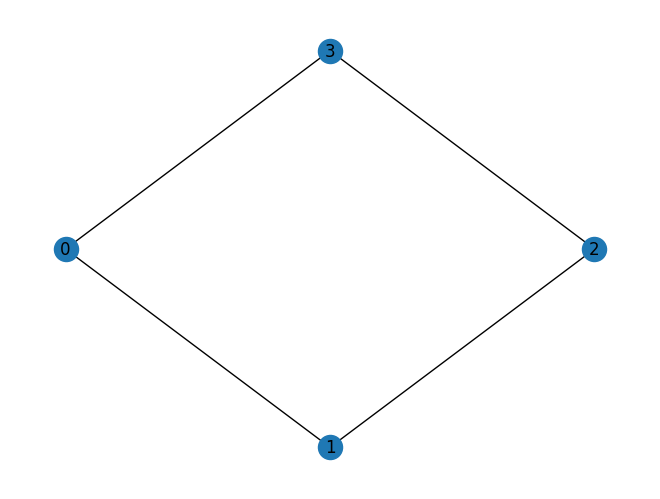

In [42]:
graph = nx.Graph([(0, 1), (1, 2), (2, 3), (0, 3)])
nx.draw_shell(graph, with_labels=True)

La primera función que vamos a ver es maxcut que nos devuelve el hamiltoniano de coste y el hamiltoniano de mezcla e imprimamos por consola qué forma tienen.

In [44]:
cost_h, mixer_h = maxcut(graph)

print(f"Hamiltoniano de coste: {cost_h}")
print(f"Hamiltoniano de mezcla: {mixer_h}")

Hamiltoniano de coste: 0.5 * (Z(0) @ Z(1)) + 0.5 * (Z(0) @ Z(3)) + 0.5 * (Z(1) @ Z(2)) + 0.5 * (Z(2) @ Z(3)) + -0.5 * (I(0) @ I(1)) + -0.5 * (I(0) @ I(3)) + -0.5 * (I(1) @ I(2)) + -0.5 * (I(2) @ I(3))
Hamiltoniano de mezcla: 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


Como podemos ver en la salida por consola ambos hamiltonianos se corresponden con las fórmulas que hemos ido obteniendo a lo largo del notebook. Vemos que para $H_c$ la suma se hace para todas las aristas del grafo y la suma de $H_M$ se hace para todos los vértices.

Veamos ahora las otras dos funciones que definen la capa de coste y la capa de mezcla.

(<Figure size 700x500 with 1 Axes>, <Axes: >)

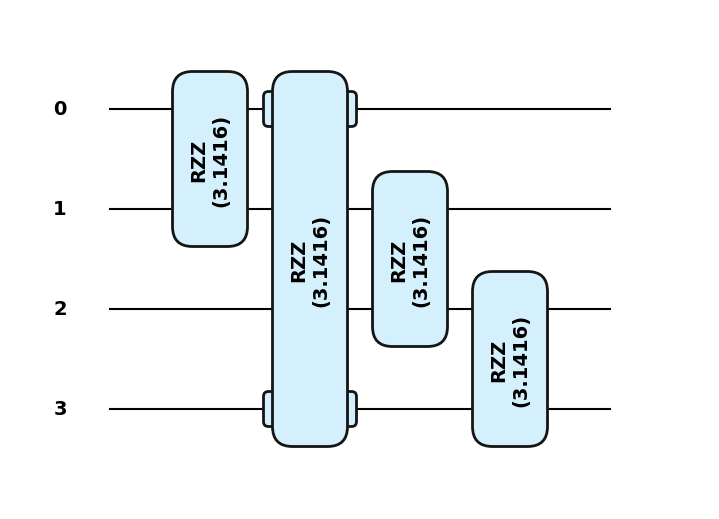

In [57]:
qml.draw_mpl(
    qml.QNode(cost_layer, qml.device("default.qubit")), # Creamos un QNode con la capa de coste y un dispositivo por defecto
    level="device",
    style="pennylane",
    decimals=4)(np.pi, cost_h) # Pasamos el parámetro gamma de la capa de coste y el Hamiltoniano de coste

Esta sería la capa de coste correspondiente al operador $e^{-i \gamma_0 H_C }$.

Podemos ver cómo ha aplicado la puerta RZZ a los pares de qubits correspondientes con las aristas del grafo. El valor de $\gamma_i$ en este ejemplo es $\pi$.

Hagamos lo mismo con el hamiltoniano de mezcla.

(<Figure size 400x500 with 1 Axes>, <Axes: >)

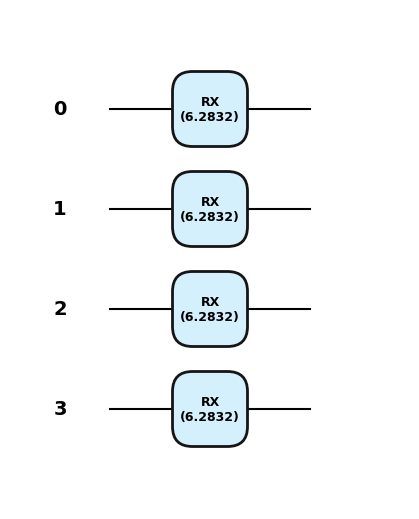

In [64]:
qml.draw_mpl(
    qml.QNode(mixer_layer, qml.device("default.qubit")), # Creamos un QNode con la capa de coste y un dispositivo por defecto
    level="device",
    style="pennylane",
    decimals=4)(np.pi, mixer_h) # Pasamos el parámetro beta de la capa de mezcla y el Hamiltoniano de mezcla

Esta es la capa de mezcla equivalente al operador de mezcla $e^{-i \beta_0 H_M}$ donde $\beta=\pi$.

Veamos ahora la función qml.layer que nos permite aplicar estas dos capas de manera consecutiva dependiendo de la profundidad p.

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

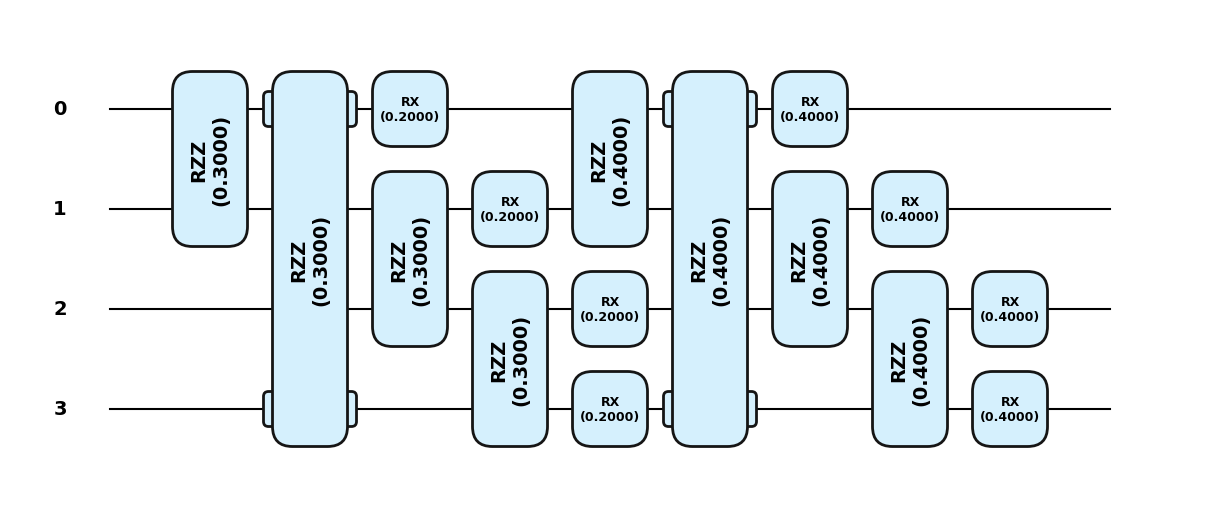

In [77]:
p = 2 # Número de capas
betas = np.array([0.1, 0.2]) # Parámetros beta
gammas = np.array([0.3, 0.4]) # Parámetros gamma
qaoa_layer = lambda beta, gamma: [cost_layer(gamma, cost_h), mixer_layer(beta, mixer_h)] # Definimos la capa QAOA

qml.draw_mpl(
    qml.QNode(qml.layer, qml.device("default.qubit")),
    level="device",
    style="pennylane",
    decimals=4)(qaoa_layer, p, betas, gammas)

Cost hamiltonian: 0.5 * (Z(0) @ Z(1)) + 0.5 * (Z(0) @ Z(3)) + 0.5 * (Z(1) @ Z(2)) + 0.5 * (Z(2) @ Z(3)) + -0.5 * (I(0) @ I(1)) + -0.5 * (I(0) @ I(3)) + -0.5 * (I(1) @ I(2)) + -0.5 * (I(2) @ I(3))
Mixer hamiltonian: 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)
Coste: -3.8682985672138357


(<Figure size 1300x500 with 1 Axes>, <Axes: >)

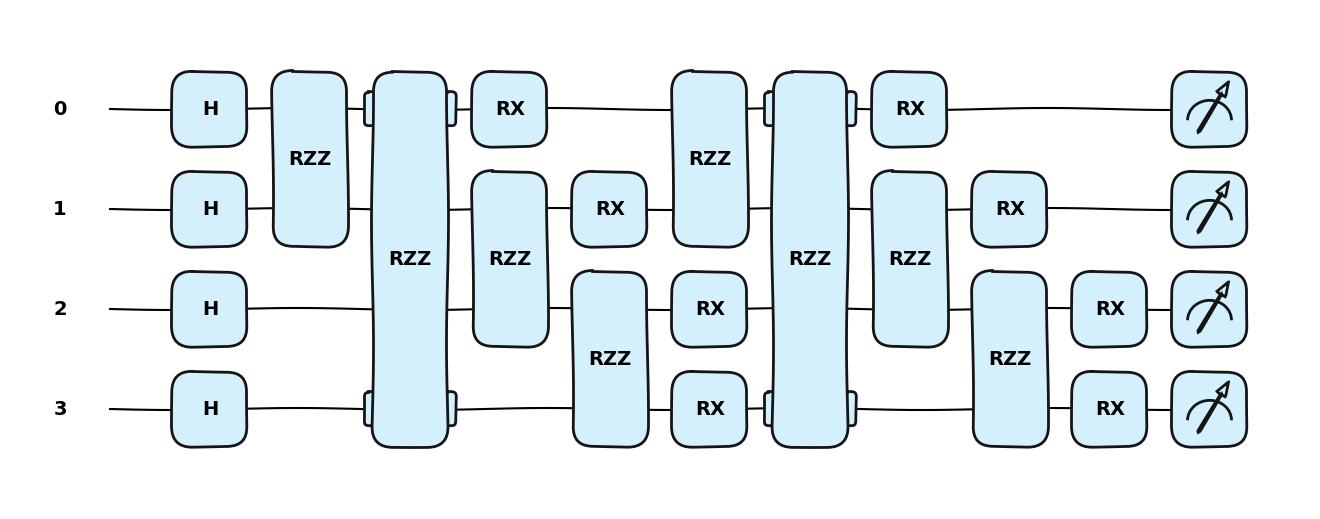

In [40]:
import pennylane as qml
from pennylane.qaoa.layers import cost_layer, mixer_layer
from pennylane.qaoa.cost import maxcut
from pennylane import numpy as np

n_wires = 4

graph = nx.Graph([(0, 1), (1, 2), (2, 3), (0, 3)])

cost_h, mixer_h = qml.qaoa.maxcut(graph)

print(f"Cost hamiltonian: {cost_h}")
print(f"Mixer hamiltonian: {mixer_h}")

def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

def circuit(params):

    for w in range(n_wires):
        qml.Hadamard(wires=w)

    qml.layer(qaoa_layer, 2, params[0], params[1])

dev = qml.device("default.qubit", wires=range(n_wires))

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    observable = 0.5*(qml.PauliZ(0) @ qml.PauliZ(1) + qml.PauliZ(1) @ qml.PauliZ(2) + qml.PauliZ(2) @ qml.PauliZ(3) + qml.PauliZ(3) @ qml.PauliZ(0)) - 0.5*(qml.Identity(0) @ qml.Identity(1) + qml.Identity(1) @ qml.Identity(2) + qml.Identity(2) @ qml.Identity(3) + qml.Identity(3) @ qml.Identity(0))
    return qml.expval(observable)

params = [[1, 1], [1, 1]]

print(f"Coste: {cost_function(params)}")

qml.draw_mpl(cost_function, level="device", style="pennylane_sketch")(params)

(<Figure size 600x400 with 1 Axes>, <Axes: >)

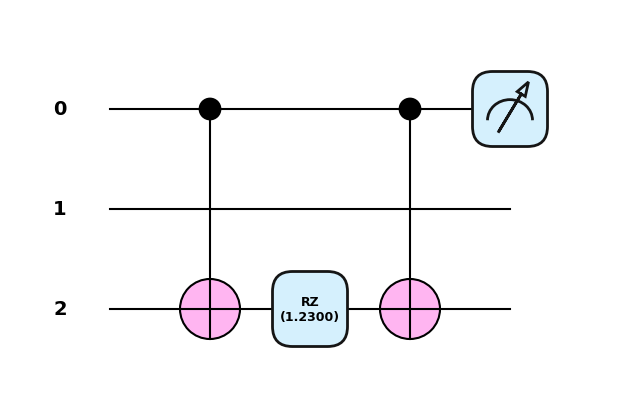

In [32]:
@qml.qnode(qml.device('default.qubit', wires=3))
def circuit(x):
    qml.CNOT(wires=[0, 2])
    qml.RZ(x, wires=2)
    qml.CNOT(wires=[0, 2])
    return qml.expval(qml.Z(0))

qml.draw_mpl(circuit, level="device", style="pennylane", show_all_wires=True, decimals=4)(1.23)

#print(qml.draw(circuit)(1.23))